In [1]:
import os
import numpy as np
from scipy.interpolate import interp1d as ip

loc_center={} ## will contain the coordinates of migration centres
sp_rate={} ## will contain location-specific functions to compute mean net diversification and net diversification min/max
freqs={} ## will contain the relative frequencies of each location

groups={'Pal':('WP','EP'), 'InSA':('SEA','IN'), 'ATM':('AF','MD'), 'AA':('AU',), 'NT':('NT',), 'Nea':('EN','WN')} ## higher level groupings of biogeographic regions

for path,dirname,fnames in os.walk('./data/'):
    for fname in fnames:
        print(path,fname)
        if fname=='area_coordinates.csv': ## coordinates for migration centers
            for line in open(os.path.join(path,fname),'r'):
                l=line.strip('\n').split('\t')
                loc,lat,lon=l
                if loc!='area':
                    loc_center[loc]=(float(lon),float(lat))
                    
        elif fname=='dispersal_prob_timeperiods.txt': ## epoch file
            dispersal_period=[0]
            for line in open(os.path.join(path,fname),'r'):
                l=line.strip('\n')
                dispersal_period.append(-int(l))
            
            dispersal_intervals=[]
            for t in range(len(dispersal_period)-1):
                dispersal_intervals.append((dispersal_period[t],dispersal_period[t+1])) ## add epoch interval

        elif 'netDiv_mean_slidingWindow.txt'==fname: ## net diversification rate file
            for line in open(os.path.join(path,fname),'r'):
                l=line.strip('\n').split('\t')
                if l[0]=='':
                    div_timeline=[-100.0]+[-float(x) for x in l[1:]]
                else:
                    loc=l[0]
                    rate=[np.nan]+[float(x) if x!='NA' else np.nan for x in l[1:]]
                    sp_rate[loc]=[div_timeline,ip(div_timeline,rate)] ## ip() is a function that interpolates the y value, given an x value

            for line in open(os.path.join(path,fname.replace('mean','min')),'r'):
                l=line.strip('\n').split('\t')
                if l[0]!='':
                    loc=l[0]
                    sp_rate[loc].append(ip(div_timeline,[np.nan]+[float(x) if x!='NA' else np.nan for x in l[1:]]))
            for line in open(os.path.join(path,fname.replace('mean','max')),'r'):
                l=line.strip('\n').split('\t')
                if l[0]!='':
                    loc=l[0]
                    sp_rate[loc].append(ip(div_timeline,[np.nan]+[float(x) if x!='NA' else np.nan for x in l[1:]]))
                
        elif 'dispersal_prob_timeStratified.txt'==fname: ## epoch-specific migration matrices
            grand_matrix={x:{} for x in dispersal_intervals}
            counter=0
            rowCount=0
            for line in open(os.path.join(path,fname),'r'):
                l=line.strip('\n').split('\t')
                if l[0]=='WN': ## header line, generate new period-specific matrix
                    locs=l
                    period=dispersal_intervals[counter]
                    grand_matrix[period]={locA:{locB:None for locB in locs} for locA in locs}
                    
                elif l[0]!='': ## not break line, just a regular matrix row
                    for i,loc in enumerate(locs):
                        period=dispersal_intervals[counter]
                        grand_matrix[period][loc][locs[rowCount]]=float(l[i])
                    rowCount+=1 ## not break line - next row
                    
                else: ## empty line - end of matrix
                    period=dispersal_intervals[counter]
                    matrix=grand_matrix[period]
                    counter+=1
                    rowCount=0
                    
        elif 'lineage_frequency_trough_time.txt'==fname: ## the relative frequency of lineages in a location
            for line in open(os.path.join(path,fname),'r'):
                l=line.strip('\n').split('\t')
                if l[0]=='time':
                    header={x:i for i,x in enumerate(l)}
                    for x in header:
                        if x not in freqs:
                            freqs[x]=[]
                else:
                    for x in header:
                        freqs[x].append(float(l[header[x]]))

locations=list(loc_center.keys())

def idPeriod(branch,matrix):
    """
    Identify the time epoch, given a branch.
    """
    
    for period in matrix:
        end,start=period
        if start<branch.absoluteTime<=end:
            return period
        
print(grand_matrix.keys())

./data/ netDiv_max_slidingWindow.txt
./data/ .DS_Store
./data/ lineage_frequency_trough_time.txt
./data/ dispersal_prob_timeperiods.txt
./data/ spec_rdm_anim.csv
./data/ ext_obs_avg_anim.csv
./data/ Nymphalidae_MCC_2866tips.tre_10areas_DECX_adjacency_dispersal.bgstates.tre
./data/ Nico_biomes.geojson
./data/ netDiv_mean_slidingWindow.txt
./data/ netDiv_min_slidingWindow.txt
./data/ ext_rdm_anim.csv
./data/ dispersal_prob_timeStratified.txt
./data/ spec_obs_avg_anim.csv
./data/ area_coordinates.csv
dict_keys([(0, -10), (-10, -30), (-30, -60), (-60, -80), (-80, -100)])


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Polygon,PathPatch,Rectangle
from matplotlib.collections import PatchCollection

import re,json,imp

bt=imp.load_source('baltic','/Users/evogytis/Documents/baltic/baltic.py') ## baltic from https://github.com/evogytis/baltic/blob/master/baltic.py

tree_path='./data/Nymphalidae_MCC_2866tips.tre_10areas_DECX_adjacency_dispersal.bgstates.tre' ## DECX tree
treestring=open(tree_path,'r').readline() ## import string

treestring=re.compile('\[').sub('[&label=""',treestring) ## convert DECX tree format into NEXUS comment format
treestring=re.compile('\]').sub('"]',treestring) ## finish DECX conversion to NEXUS

colours={"WP": "#4c72a5",
         "EP": "#77bedb",
         "EN": "#48a365",
         "WN": "#52cda7",
         "AF": "#d0694a",
         "MD": "#852405",
         "NT": "#e1c72f",
         "IN": "#ccc197",
         "AU": "#cc79a7",
         "SEA":"#7f6e85"} ## colour scheme
    
ll=bt.make_tree(treestring) ## turn tree string into data structure
ll.traverse_tree() ## traverse tree (sets heights)
ll.setAbsoluteTime(0.0) ## set absolute time for branches
ll.sortBranches() ## sort tree
ll.treeStats() ## report stats

for k in ll.Objects:
    k.traits['label']=k.traits['label'].split('_') ## convert bioregions string of each branch into a list of values
    
for k in ll.Objects: ## iterate over branches
    k.traits['migration']=set() ## initiate a set class for migrations
    if 'label' in k.parent.traits: ## branches has annotations
        parental=set(k.parent.traits['label']) ## convert parental locations to set
        descendant=set(k.traits['label']) ## convert current locations to set
        if parental!=descendant: ## sets are not identical (one or the other has more locations)
            new_locations=descendant.difference(parental) ## new locations are current locations minus parental locations
            if len(new_locations)>0: ## at least one location on descendant branch is not present in parent
                period=idPeriod(k,grand_matrix) ## identify epoch of branch
                mig_matrix=grand_matrix[period] ## get migration matrix from period

                probs={'%s_%s'%(ori,des):mig_matrix[ori][des] for ori in parental for des in new_locations} ## get probabilities for every possible origin for new arrivals

                choices=[key for key in probs if probs[key]==max(probs.values())] ## get migrations with highest scores
                assigned=np.random.choice(np.array(choices),size=1)[0] ## pick one at random (if there's only one possibility it will be chosen)
                ultimateOrigin=assigned.split('_')[0] ## get the origin
                for des in new_locations: ## every new location for a lineage traces its source to a single origin
                    k.traits['migration'].add('%s_%s'%(ultimateOrigin,des)) ## add migration from assigned origin to every location


Tree height: 84.240943
Tree length: 25310.053987
strictly bifurcating tree
annotations present

Numbers of objects in tree: 5731 (2866 nodes and 2866 leaves)



In [3]:
json_map=json.load(open('./data/Nico_biomes.geojson','r')) ## import geojson of global polygons

features=json_map['features'] ## get features
location_points={} ## location points will be stored here
polygons={} ## polygons will be stored here

locName='biome' ## key name for each feature

# holes=[]

for loc in features: ## iterate through features (locations)
    poly = np.asarray(loc['geometry']['coordinates']) ## get coordinates
#     location=removeDiacritics(loc['properties'][locName]) ## standardised location name (remove diacritics)
    location=loc['properties'][locName]
    polygons[location]=[]
    location_points[location]=[]
#     if len(poly[1])==1 and len(poly[0])!=1:
    if loc['geometry']['type']=='MultiPolygon': ## multiple parts detected
#         print(location,[np.array(part).shape for part in poly])
        
        for p,part in enumerate(poly): ## iterate over each component polygon
            part=np.asarray(part)
#             print(part.shape)
#             if len(np.array(part).shape)>1 and np.array(part).shape[1]==5:
                
            for c,coords in enumerate(part): ## iterate over coordinates
                
                coords=np.array(coords)
#                 print(location,p,c,coords.shape)
                if c==0: ## the moment c>0 it's holes
                    xs=coords[:,0] ## longitudes
                    ys=coords[:,1] ## latitudes
                    assert(len(xs.shape)==1 and len(ys.shape)==1)
                    location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
#                 elif coords.shape[0]>20:
                    
#                     xs=coords[:,0] ## longitudes
#                     ys=coords[:,1] ## latitudes
# #                     print(c,xs,ys)
#                     assert(len(xs.shape)==1 and len(ys.shape)==1)
#                     holes.append(np.vstack(zip(xs,ys)))
# #                     location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates
# #     if loc['geometry']['type']=='Polygon': ## location is single part
# #         for coords in np.asarray(poly): ## iterate over coordinates
# #             coords=np.array(coords)
# #             xs=coords[:,0] ## longitudes
# #             ys=coords[:,1] ## latitudes
# #             location_points[location].append(np.vstack(zip(xs,ys))) ## append coordinates to location's list of coordinates

    complete_location=[]
    for part in location_points[location]: ## iterate over each component of a location
#         complete_location.append(PathPatch(part))
        complete_location.append(Polygon(part,True)) ## create a polygon for each component of a location

    polygons[location]=complete_location ## assign list of polygons to a location
        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


WN (-114.390206, 46.396794)
EN (-86.006272, 36.621777)
NT (-65.130565, -2.383034)
WP (11.664569, 48.173367)
EP (90.04452, 51.11873)
AF (26.994271, -1.824846)
MD (46.935283, -19.299668)
IN (78.62502, 21.179732)
SEA (102.6125, 14.663178)
AU (136.289734, -23.656813)


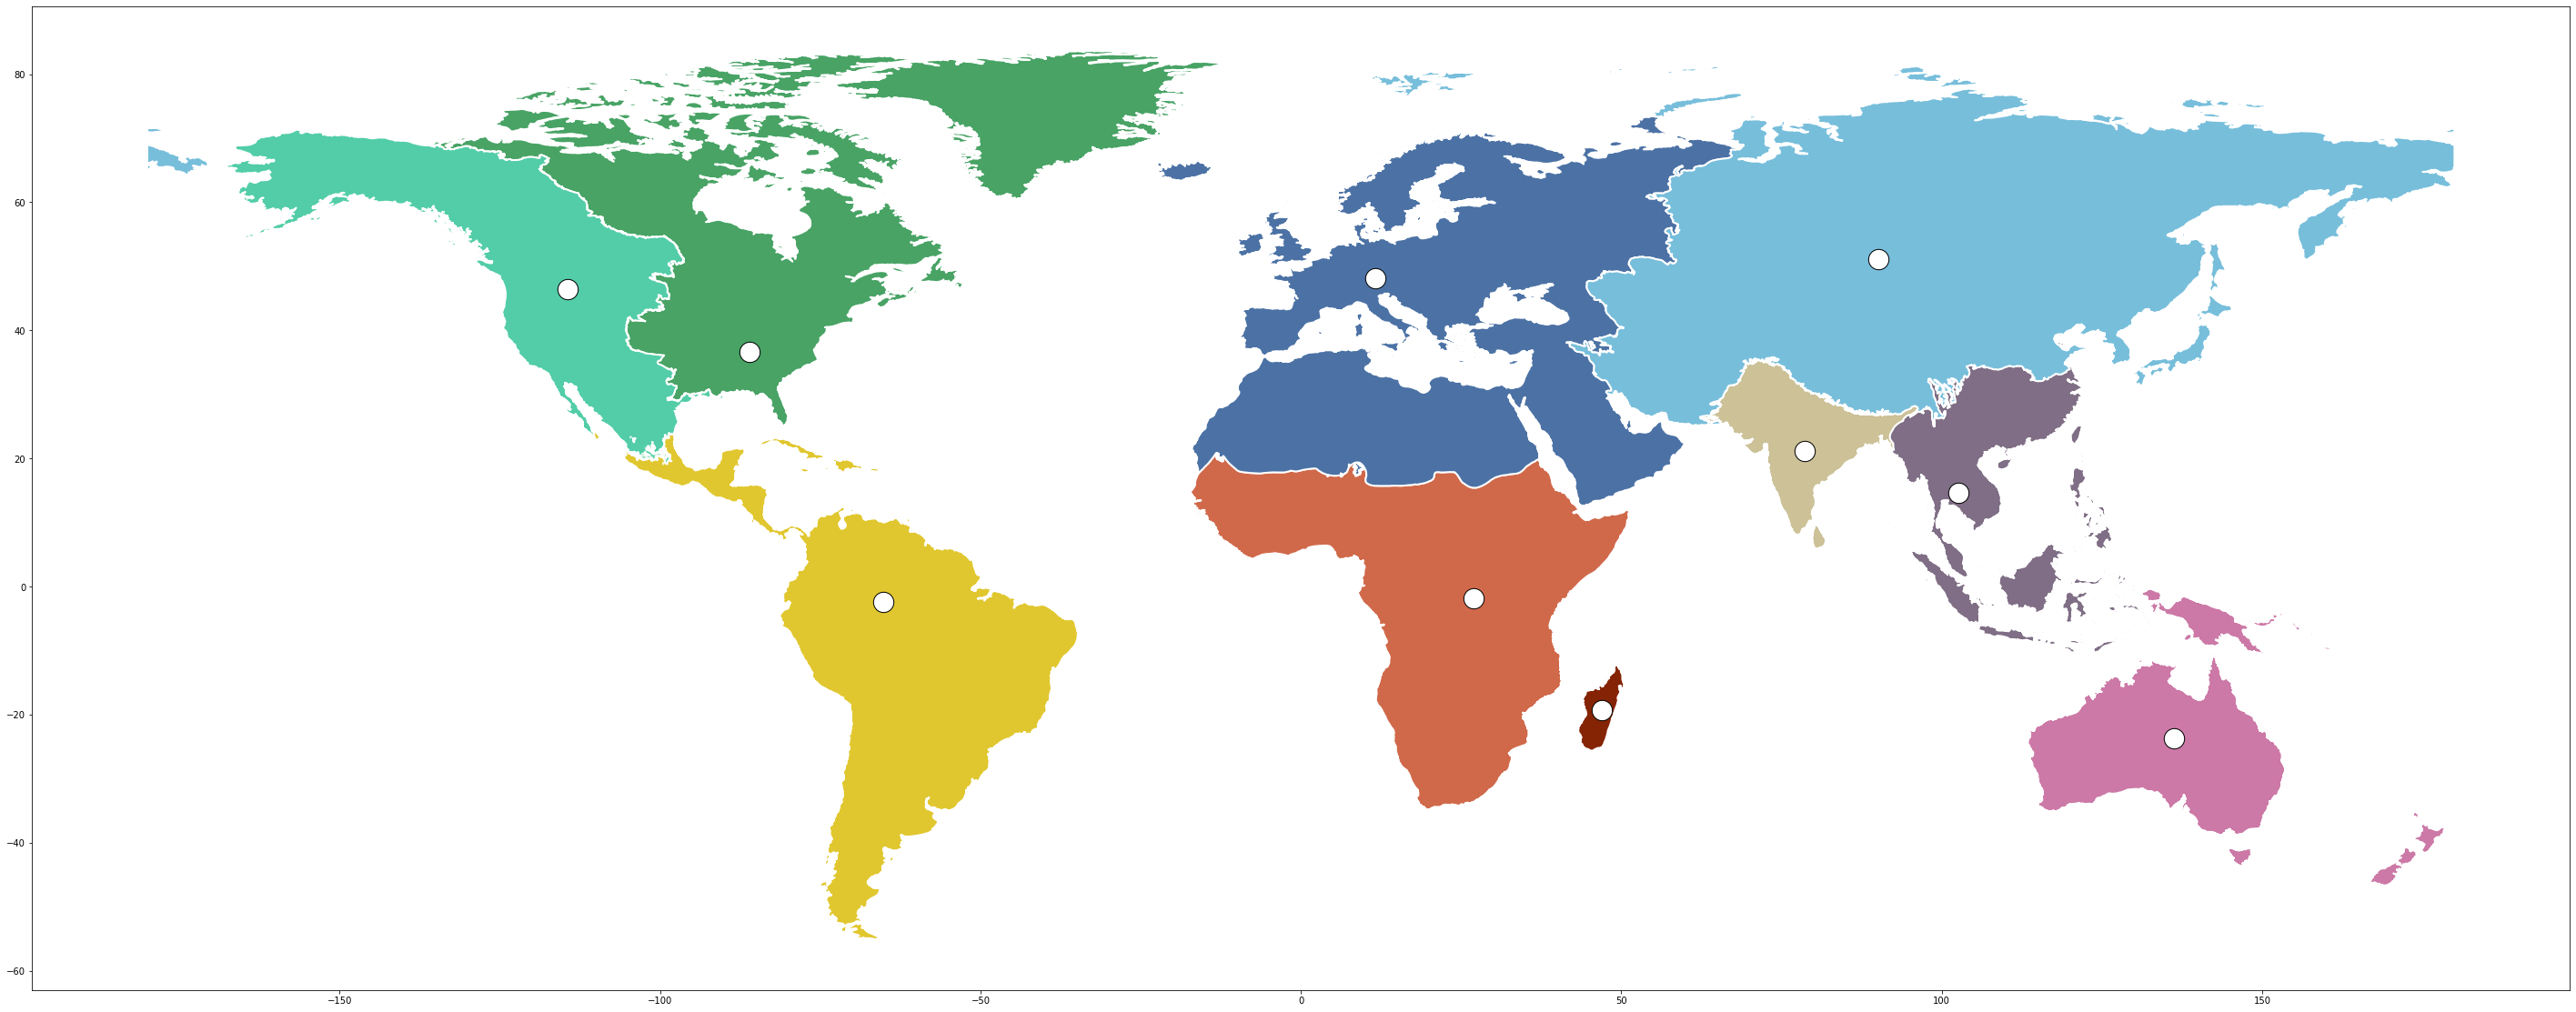

In [4]:
fig,ax = plt.subplots(figsize=(50,50),facecolor='w')

for l,loc in enumerate(polygons):
    county=PatchCollection(polygons[loc],facecolor=colours[loc],edgecolor='w',lw=2,zorder=1)
    ax.add_collection(county)

for loc in loc_center:
    print(loc,loc_center[loc])
    ax.scatter(*loc_center[loc],s=500,facecolor='w',edgecolor='k',zorder=200)

ax.plot()
ax.set_aspect(1)
plt.show()

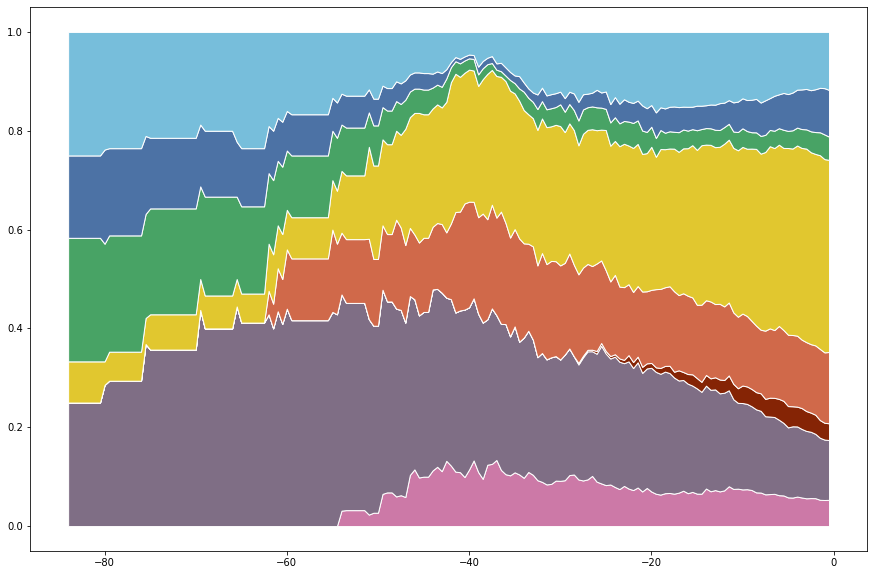

In [5]:
fig = plt.figure(figsize=(15, 10),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.01) 

ax=plt.subplot(gs[0],facecolor='w')

locs=['AA','InSA','MD','AF','NT','Nea','WP','EP']
xs=freqs['time']
for i,loc in enumerate(locs):
    fc=colours[loc] if loc in colours else colours[groups[loc][0]]
    bottom=[freqs[l] for l in locs[:i]]
    if len(bottom)==0:
        bottom=[0 for x in xs]
    else:
        bottom=np.sum(np.array(bottom),axis=0)
    top=[a+b for a,b in zip(bottom,freqs[loc])]
    ax.fill_between(xs,bottom,top,facecolor=fc,edgecolor='w')
    
plt.show()

In [6]:
import bezier

def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate

control=lambda d:100*(1/d)**0.5 ## function that will convert the distance between migration points into a distance to be used for finding the control point for a Bezier function

for k in ll.Objects:
    if len(k.traits['migration'])>0:
        k.traits['migration_curves']=[]
        for migration in k.traits['migration']:
            ori,des=migration.split('_')
            A=loc_center[ori] ## fetch origin
            B=loc_center[des] ## fetch destination
            d=np.sqrt((B[1]-A[1])**2 + (B[0]-A[0])**2) ## calculate distance between location A and location B
            
            bez_points=[A,Bezier_control(A,B,control(d)*(1+np.random.random()*3.0),0.5),B]
            bez_points=np.array(bez_points).transpose()
            curve = bezier.Curve(np.asfortranarray(bez_points),degree=len(bez_points)) ## Bezier curve object
            
            k.traits['migration_curves'].append(curve.evaluate_multi)

[=================================                 ]  66.67%  frame:    20 -26.379310344827587  time:  3.21 min  ETA:  1.60 min (0.16035 s/operation)

DONE!

Time taken: 149.34 minutes


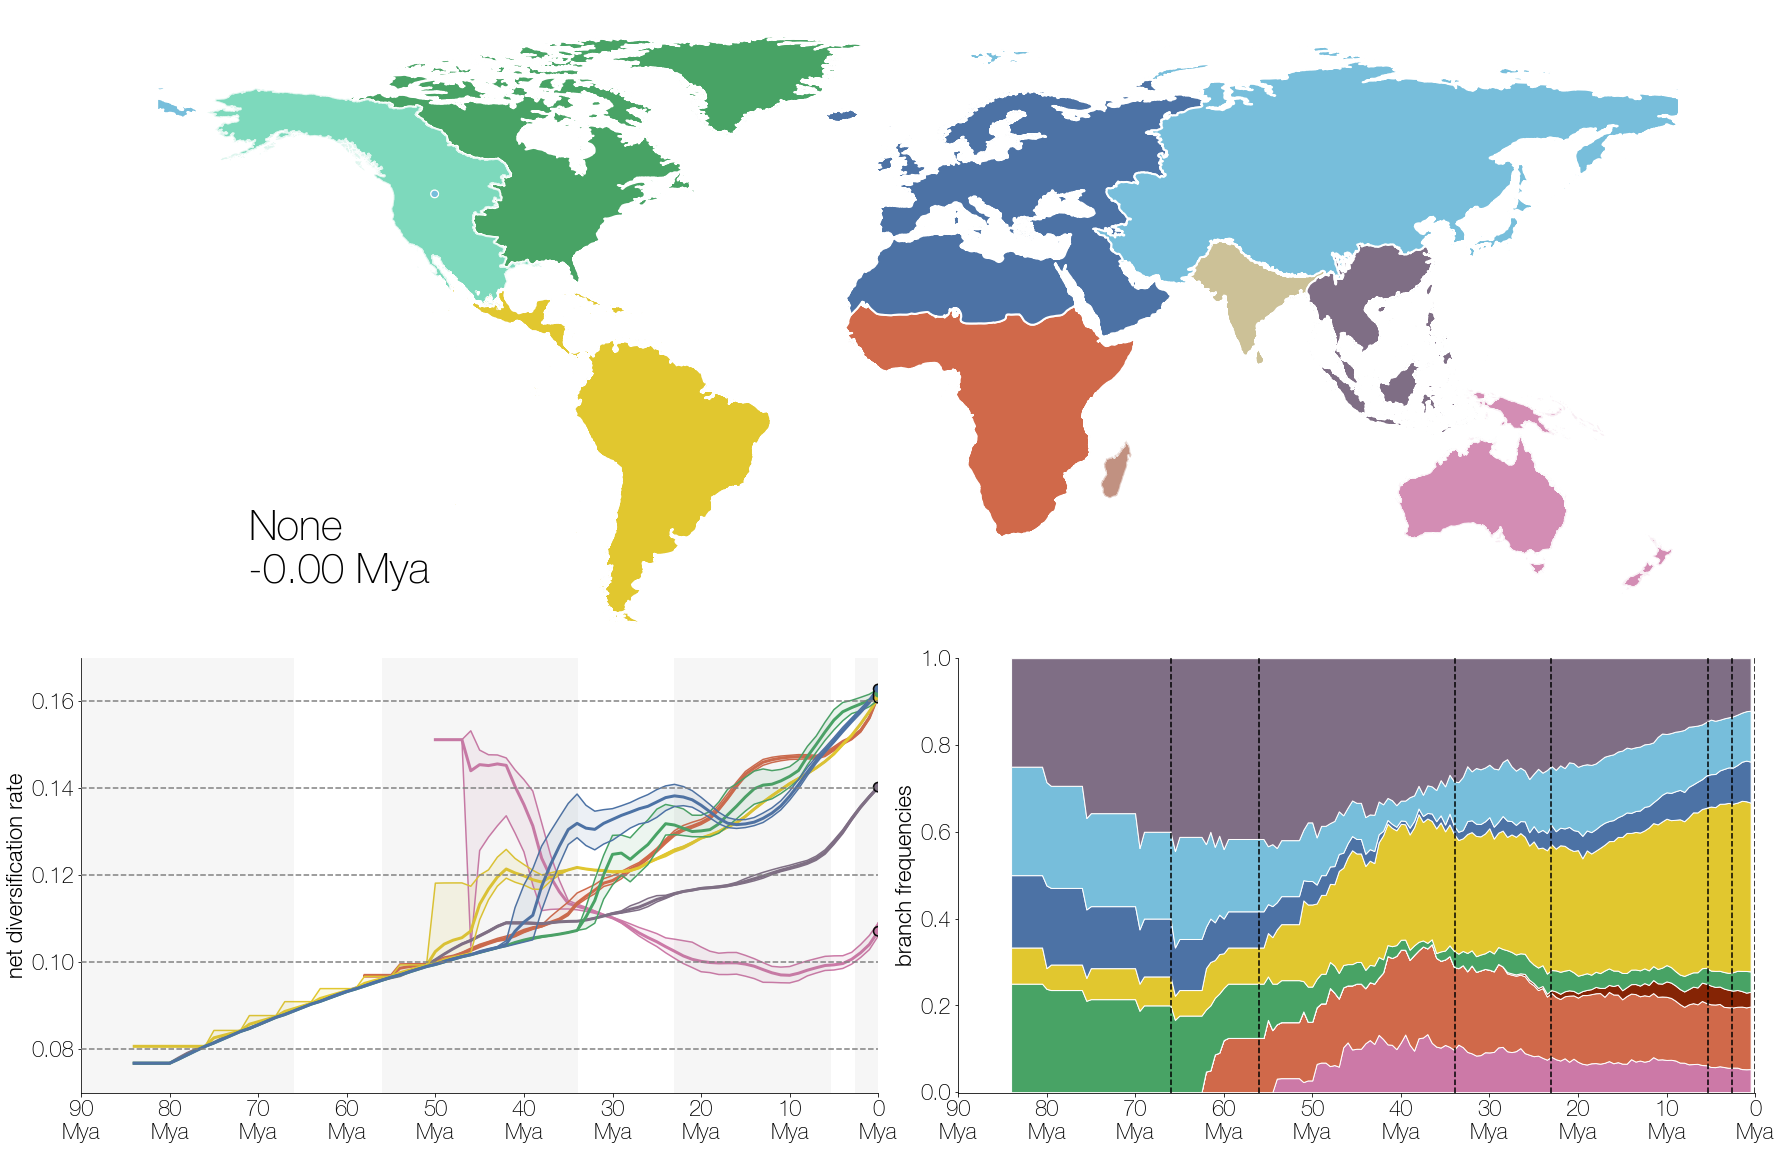

In [7]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import clear_output

typeface='Helvetica Neue'
mpl.rcParams['mathtext.fontset']='custom'
mpl.rcParams['font.sans-serif']=typeface
mpl.rcParams['mathtext.default']='sf'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import time,sys

smooth=10 ## how many segments Bezier lines will have

depth=1 ## how long the migration takes place (1 Myr here)
departure_condition = lambda f:f-0.3 ## determines how far away (in Bezier fraction) the tail of the migrating lineage is
transition_point=0.0 ## determines the fixed time point along a branch at which migration happens

t0 = time.time() ## time how long animation takes

figWidth=10 ## map figure width
dpi=150 ## dots per inch for each .png (90 used in the final version)

bt_tree=ll

animation_grid=list(np.linspace(-85,0,30)) ## grid of time points for which to generate frames

print('Start of animation: %.2f\nEnd: %.2f'%(min(animation_grid),max(animation_grid)))
print('Number of frames to animate: %d'%(len(animation_grid)))
            
global travelers ## the animation will need to have information to traveling lineages

travelers=[x for x in bt_tree.Objects if len(x.traits['migration'])>0] # find lineages that have travelled - they're what's going to be animated

print('\nNumber of travelling lineages: %d (%.3f%% of all lineages)'%(len(travelers),len(travelers)/float(len(bt_tree.Objects))*100))

plt.figure(figsize=(30,20),facecolor='w') ## start figure

gs = gridspec.GridSpec(2, 2,height_ratios=[0.6,0.4],width_ratios=[1,1],wspace=0.1,hspace=0.0) ## using gridspec to set up several plots
ax1 = plt.subplot(gs[0,0:]) ## ax1 is map
ax2 = plt.subplot(gs[1,1]) ## ax2 is frequencies
ax3 = plt.subplot(gs[1,0]) ## ax3 is diversification rates

periods={'Cretaceous':(-145,-66),'Paleocene':(-66,-56),
     'Eocene':(-56,-33.9),'Oligocene':(-33.9,-23.03),
     'Miocene':(-23.03,-5.333),'Pliocene':(-5.333,-2.58),
     'Pleistocene':(-2.58,0)} ## names of time periods

for p,per in enumerate(periods):
    if p%2==0:
        l,u=periods[per]
        ax3.axvspan(l,u,facecolor='grey',alpha=0.07,zorder=11) ## plot grey rectangle for each time period
    ax2.axvline(periods[per][-1],color='k',ls='--',zorder=11) ## plot dotted line for time period boundaries
    
for i,loc in enumerate(sorted(sp_rate)): ## for every location
    xs,ys,yl,yu=sp_rate[loc] ## get x coordinates and functions to plot mean, min and max of net diversification
    
    c=colours[groups[loc][0]] ## get location colour
    
    ax3.plot([-80,-80],[ys(animation_grid[0]),ys(animation_grid[0])],color=c,lw=3,zorder=8,label='%s_confidence'%(loc),solid_capstyle='round') ## plot mean diversification rate confidence interval width
    ax3.scatter(-80,ys(animation_grid[0]),60,facecolor=c,edgecolor='none',zorder=10,label='%s_mean'%(loc))
    ax3.scatter(-80,ys(animation_grid[0]),120,facecolor='k',edgecolor='none',zorder=9,label='%s_mean'%(loc)) ## line terminates with a circle
    
    ys=ys(xs)
    yl=yl(xs)
    yu=yu(xs)
    ax3.plot(xs,ys,color=c,lw=3,zorder=1) ## plot mean net diversification rate
    ax3.fill_between(xs,yl,yu,facecolor=c,alpha=0.1,zorder=0) ## plot polygon defined by the upper and lower confidence intervals
    
    ax3.plot(xs,yl,color=c,zorder=1) ## plot lines for upper and lower confidence intervals
    ax3.plot(xs,yu,color=c,zorder=1)
    
cover_rect=plt.Rectangle((0.0,0.071),100,0.17,facecolor='w',edgecolor='none',zorder=4,label='cover') ## cover up plot with a white rectangle that will obscure lines
ax3.add_patch(cover_rect) ## add covering rectangle to plot
ax3.plot() ## make sure things are actually dumped into the axes

xpos=np.arange(-90,0.001,10) ## define timeline tick positions
xlabels=['%s\nMya'%(int(-t)) for t in xpos] ## generate tick labels

ax3.set_xticks(xpos) ## set tick positions
ax3.set_xticklabels(xlabels) ## set tick labels
ax3.set_ylim(0.07,0.17) ## limit y axis
ax3.set_xlim(-90,0.0) ## limit x axis

[ax3.axhline(x,ls='--',color='grey',zorder=12) for x in np.arange(0.06,0.18,0.02)] ## add y grid lines
[ax3.spines[loc].set_visible(False) for loc in ['top','right']] ## remove axis spines
ax3.set_ylabel('net diversification rate') ## add y axis label

for loc in polygons.keys(): ## iterate over locations
    fc='none' ## assume polygon transparent
    ec='k' ## polygon edge is black
    al=0.1 ## transparency is high
    if loc in ll.root.traits['label']: ## if polygon in the set of regions at the root of the tree
        fc=colours[loc] ## change colour to location colour
        ec='w' ## edges are white
        al=1.0 ## polygon not transparent
    poly=PatchCollection(polygons[loc],facecolor=fc,edgecolor=ec,lw=2,label='%s_polygon'%(loc),zorder=95) ## location polygon
    poly.set_alpha(al) ## set transparency for polygon
    ax1.add_collection(poly) ## add location polygon to plot
    
ax1.plot() ## dump objects onto axis

[ax1.spines[loc].set_visible(False) for loc in ax1.spines] ## remove borders and axis labels
ax1.tick_params(size=0) ## no ticks
ax1.set_xticklabels([]) ## no tick labels
ax1.set_yticklabels([])
ax1.set_aspect(1) ## aspect ratio == 1

locs=['AA', 'AF', 'MD', 'Nea', 'NT', 'WP', 'EP', 'InSA'] ## canonical order for locations in the frequency subplot
xs=freqs['time'] ## get x coordinates
for i,loc in enumerate(locs): ## iterate over locations
    fc=colours[loc] if loc in colours else colours[groups[loc][0]] ## get location colour
    bottom=[freqs[l] for l in locs[:i]] ## get all frequencies up to current location at each time point
    if len(bottom)==0: ## if current location is first, bottom is all 0
        bottom=[0 for x in xs]
    else: ## otherwise sum frequencies at each time point
        bottom=np.sum(np.array(bottom),axis=0)
    top=[a+b for a,b in zip(bottom,freqs[loc])] ## top is bottom+current frequencies
    ax2.fill_between(xs,bottom,top,facecolor=fc,edgecolor='w') ## add frequency polygon

cover_rect=plt.Rectangle((-89.999,0.0),100,1.0,facecolor='w',edgecolor='none',zorder=4,label='cover') ## another white rectangle sitting on top of frequencies
ax2.add_patch(cover_rect) ## add to axis

[ax2.spines[loc].set_visible(False) for loc in ['top','right']] ## remove spines
ax2.set_ylabel('branch frequencies') ## add y axis label
ax2.set_xticks(xpos) ## set x tick positions
ax2.set_xticklabels(xlabels) ## set x tick labels
ax2.set_xlim(-90,0) ## set x axis limits
ax2.set_ylim(-0.001,1.001) ## set y axis limits

def epoch(time):
    """
    Given a time return the corresponding time period.
    """
    periods={'Cretaceous':(-145,-66),'Paleocene':(-66,-56),
     'Eocene':(-56,-33.9),'Oligocene':(-33.9,-23.03),
     'Miocene':(-23.03,-5.333),'Pliocene':(-5.333,-2.58),
     'Pleistocene':(-2.58,0)}

    for p in periods:
        low,up=periods[p]
        if low<=time<up:
            return p

def animate(frame): ## generate frame
    #### Primary plotting (map)
    ax1.lines=[line for line in ax1.lines if 'border' in line.get_label()] ## reset lines (except borders) and texts in the plot
    ax1.texts=[] ## remove all text from plot
    
    if len(animation_grid)-1==frame: ## if at last frame
        next_time=animation_grid[frame] ## current frame is next frame
    else:
        next_time=animation_grid[frame+1] ## next frame
        
    current_time=animation_grid[frame] ## fetch what time it is in the current frame
    
    ax1.text(0.1,0.1,'%s\n%.2f Mya'%(epoch(current_time),-current_time),size=42,va='bottom',ha='left',transform=ax1.transAxes) ## add text showing time period and time
    
    effects=[path_effects.Stroke(linewidth=4, foreground='white'),
                 path_effects.Stroke(linewidth=0.5, foreground='k')] ## black text, white outline formatting
    
    for k in travelers: ## iterate through travelling lineages
        transition=k.parent.absoluteTime+k.length*transition_point ## fixed point at which lineage reaches destination
        
        if current_time-depth<transition<current_time+depth: ## make sure transition is within period of animation
            frac=1-(transition-current_time)/float(depth) ## frac will go from 0.0 to 2.0
            
            for migration,mcurve in zip(k.traits['migration'],k.traits['migration_curves']): ## iterate over migrations happening at the branch
                ori,des=migration.split('_') ## fetch source and destination
                fc=colours[ori] ## fetch appropriate colour (of origin region)
            
                lineage_tail=departure_condition(frac) ## Bezier line begins at half a fraction along the path
                lineage_head=frac

                lineage_tail,lineage_head=np.clip([lineage_tail,lineage_head],0.0,1.0) ## clip fractions to be within interval (0.0,1.0)
                if lineage_head==1.0: ## if a lineage has arrived
                    for polygon in [p for p in ax1.collections if p.get_label()=='%s_polygon'%(des)]: ## get polygon that is destination
                        if len(polygon.get_facecolor())==0: ## if the facecolor has been set to None (the region hasn't had lineages yet)
                            polygon.set_facecolor(colours[des]) ## change the colour of location to what it should be
                            polygon.set_edgecolor('w') ## edge colour is now white
                            polygon.set_alpha(0.101) ## make polygon less transparent
                            
                eval_Bezier=np.linspace(lineage_tail,lineage_head,smooth) ## generate points along which Bezier line will be generated
                
                line=mcurve(eval_Bezier) ## get coordinates of Bezier curve
                xs,ys=line ## split into x and y coordinates
                if lineage_head>0.0 and lineage_tail<1.0: ## only plot if line begins before destination
                    for q in range(len(xs)-1): ## iterate through Bezier line segments with fading alpha and reducing width
                        x1,y1=xs[q],ys[q] ## get coordinates for current segment's start
                        x2,y2=xs[q+1],ys[q+1] ## get coordinates for current segment's end

                        segL=(q+1)/float(len(xs)) ## fraction along length of Bezier line

                        ax1.plot([x1,x2],[y1,y2],lw=7*segL,alpha=1,color=fc,zorder=99,solid_capstyle='round') ## plot actual lineage
                        ax1.plot([x1,x2],[y1,y2],lw=10*segL,alpha=1,color='w',zorder=98,solid_capstyle='round') ## plot underlying white background to help lineages stand out
    
    for loc_polygon in [p for p in ax1.collections if 'polygon' in p.get_label()]: ## get all polygons
        if len(loc_polygon.get_edgecolor())==1 and 0.1<loc_polygon.get_alpha()<1.0: ## if polygon is not completely opaque
            incr=0.05 ## increment its opaqueness
            new_alpha=loc_polygon.get_alpha()+incr
            if new_alpha>1.0: ## check if opaqueness is greater than 1.0 (not allowed)
                loc_polygon.set_alpha(1.0)
            else:
                loc_polygon.set_alpha(new_alpha)
                
    update=10 ## update progress bar every X frames
    
    for loc in groups: ## iterate over regions
        for sc in ax3.collections: ## get all objects in diversification plot
            if '%s_mean'%(loc) == sc.get_label(): ## if looking at the point indicating mean
                lo,_=sc.get_label().split('_')
                sc.set_offsets((current_time,sp_rate[lo][1](current_time))) ## offset x coordinate to what the current time is
        for conf in ax3.lines: ## repeat for line indicating uncertainty
            if '%s_confidence'%(loc) == conf.get_label():
                lo,_=conf.get_label().split('_')
                conf.set_zorder(8)
                conf.set_ydata([sp_rate[lo][2](current_time),sp_rate[lo][3](current_time)])
                conf.set_xdata([current_time,current_time])
                
    for rect in [p for p in ax3.patches if p.get_label()!='']: ## move both covering rectangles away, revealing what's underneath
        rect.set_x(current_time)
    for rect in [p for p in ax2.patches if p.get_label()=='cover']:
        rect.set_x(current_time)

    if frame>0 and frame%update==0: ## progress bar
        clear_output()
        timeElapsed=(time.time() - t0)/60.0
        progress=int((frame*(50/float(len(animation_grid)))))
        percentage=frame/float(len(animation_grid))*100
        rate=timeElapsed/float(frame)
        ETA=rate*(len(animation_grid)-frame)
        
        sys.stdout.write("[%-50s] %6.2f%%  frame: %5d %10s  time: %5.2f min  ETA: %5.2f min (%6.5f s/operation)" % ('='*progress,percentage,frame,animation_grid[frame],timeElapsed,ETA,rate))
        sys.stdout.flush()

for frame in range(len(animation_grid)): ## iterate through each frame
    animate(frame) ## animate will modify the map, tree and cases
    plt.savefig('/Users/evogytis/Dropbox/Jupyter_notebooks/NicoChazot_animation/animation_frames/sim_ani_frame_%05d.png'%(frame), format='png',bbox_inches='tight',dpi=dpi) ## save individual frames for stitching up using 3rd party software (e.g. FFMpeg)

print('\n\nDONE!')

print('\nTime taken: %.2f minutes'%((time.time() - t0)/60.0))

plt.show()

In [8]:
%%bash

frames=/Users/evogytis/Dropbox/Jupyter_notebooks/NicoChazot_animation/animation_frames
# ls $frames
cd  $frames; rm Nico_animation_v6.mp4; ffmpeg -framerate 1 -start_number 0 -i sim_ani_frame_%05d.png -pix_fmt yuv420p -b:a 64k -vf scale="2160:trunc(ow/a/2)*2" Nico_animation_v6.mp4


ffmpeg version 4.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/miniconda2 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from 'sim_ani_frame_%05d.png':
  Duration: 00:00:30.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 3713x2394 [SAR 5905:5905 DAR 